In [1]:
%%time

import fastai
from fastai.vision.all import *
from pathlib import Path
import cal_MAP5
from sklearn import model_selection

CPU times: user 1.43 s, sys: 1.11 s, total: 2.54 s
Wall time: 1.94 s


In [2]:
train_merged = pd.read_csv("train_validation.csv")

display(train_merged.head())

,image,species,individual_id,total_count,is_valid
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,1,False
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,2,False
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,64,False
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,65,False
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,50,True


In [3]:
train_merged["is_valid"].value_counts()

False    43467
True      7566
Name: is_valid, dtype: int64

In [4]:
def create_folds(df):
    '''this function creates 5 stratified folds
    '''
    kf = model_selection.StratifiedKFold(n_splits = 5, random_state = 240, shuffle = True)
    
    for f, (t_, v_) in enumerate(kf.split(X = df["image"], y = df["individual_id"])) :
        df.loc[v_, "kfold"] = f

In [5]:
path = Path.cwd()/"train_images/"

In [6]:
path.ls()

(#51034) [Path('/home/train_images/00021adfb725ed.jpg'),Path('/home/train_images/000562241d384d.jpg'),Path('/home/train_images/0007c33415ce37.jpg'),Path('/home/train_images/0007d9bca26a99.jpg'),Path('/home/train_images/00087baf5cef7a.jpg'),Path('/home/train_images/000a8f2d5c316a.jpg'),Path('/home/train_images/000be9acf46619.jpg'),Path('/home/train_images/000bef247c7a42.jpg'),Path('/home/train_images/000c3d63069748.jpg'),Path('/home/train_images/000c476c11bad5.jpg')...]

In [7]:
whales = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = ColReader('image', path),
                   get_y = ColReader('individual_id'),
                   splitter = ColSplitter('is_valid'),
                   item_tfms = Resize(440),
                   batch_tfms = [*aug_transforms(size = 224, min_scale = 0.75)])

In [8]:
%%time
dls = whales.dataloaders(train_merged)

CPU times: user 7.07 s, sys: 1.29 s, total: 8.36 s
Wall time: 8.3 s


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


CPU times: user 6.49 s, sys: 499 ms, total: 6.99 s
Wall time: 6.75 s


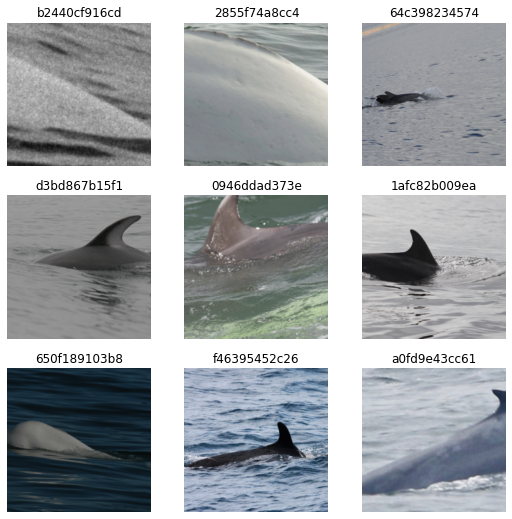

In [9]:
%%time
dls.show_batch()

CPU times: user 1.59 s, sys: 57.2 ms, total: 1.65 s
Wall time: 1.42 s


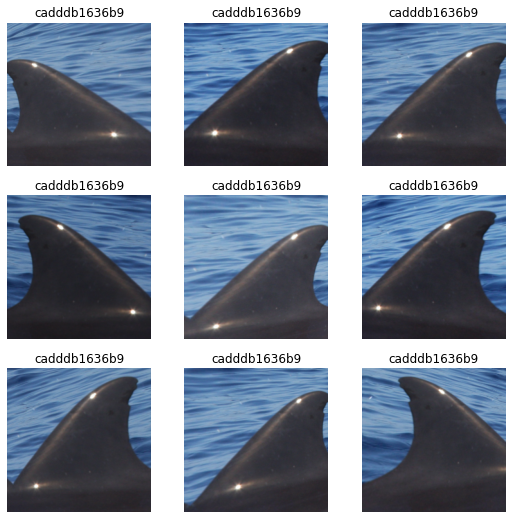

In [10]:
%%time
dls.show_batch(unique = True)

In [11]:
%%time

learn = cnn_learner(dls, resnet50, metrics = error_rate).to_fp16()

CPU times: user 770 ms, sys: 61.6 ms, total: 832 ms
Wall time: 588 ms


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 15.3 s, sys: 1.77 s, total: 17.1 s
Wall time: 1min 50s


SuggestedLRs(valley=0.00363078061491251)

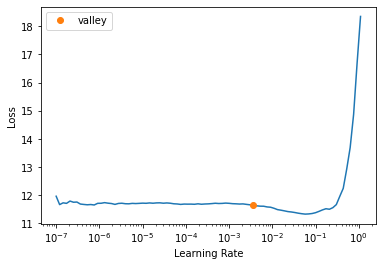

In [39]:
%%time

learn.lr_find()

In [12]:
%%time

learn.fit_one_cycle(5, 1e-3, cbs = SaveModelCallback(every_epoch = True))

epoch,train_loss,valid_loss,error_rate,time
0,9.153123,7.468233,0.962464,13:38
1,8.019428,6.342961,0.924266,13:35
2,7.488902,5.866518,0.892546,13:34
3,7.036666,5.603617,0.865054,13:31
4,6.774365,5.562332,0.862146,13:35


CPU times: user 9min 34s, sys: 42.8 s, total: 10min 17s
Wall time: 1h 7min 56s


In [13]:
learn.export("baseline-resnet50.pkl")

In [6]:
learn = load_learner("models/baseline-resnet50.pkl")

In [22]:
dls.valid

In [23]:
preds, act = learn.get_preds(dl = dls.valid)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
accuracy(preds, act)

TensorBase(0.0297)

In [26]:
len(preds)

7566

In [27]:
act

TensorCategory([8721, 4153, 7354,  ..., 5116, 3909, 4715])

In [28]:
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

In [30]:
cal_MAP5.map_per_set(preds_sorted, act)

0.051912062736805

In [3]:
test_imgs = os.listdir("test_images/")
test_imgs[:5]

['000110707af0ba.jpg',
 '0006287ec424cb.jpg',
 '000809ecb2ccad.jpg',
 '00098d1376dab2.jpg',
 '000b8d89c738bd.jpg']

In [4]:
test = pd.DataFrame()
test["image"] = test_imgs
test["label"] = -1
display(test.head())

,image,label
0,000110707af0ba.jpg,-1
1,0006287ec424cb.jpg,-1
2,000809ecb2ccad.jpg,-1
3,00098d1376dab2.jpg,-1
4,000b8d89c738bd.jpg,-1


In [5]:
path_test = Path.cwd()/"test_images/"

In [42]:
%%time
torch.cuda.empty_cache()

CPU times: user 3.35 ms, sys: 80 ms, total: 83.3 ms
Wall time: 81.8 ms


In [21]:
help(learn.dls.test_dl)

Help on method test_dl in module fastai.data.core:

test_dl(test_items, rm_type_tfms=None, with_labels=False, bs=64, shuffle=False, num_workers=None, verbose=False, do_setup=True, pin_memory=False, timeout=0, batch_size=None, drop_last=False, indexed=None, n=None, device=None, persistent_workers=False, *, wif=None, before_iter=None, after_item=None, before_batch=None, after_batch=None, after_iter=None, create_batches=None, create_item=None, create_batch=None, retain=None, get_idxs=None, sample=None, shuffle_fn=None, do_batch=None) method of fastai.data.core.DataLoaders instance
    Create a test dataloader from `test_items` using validation transforms of `dls`



In [22]:
help(learn.dls)

Help on DataLoaders in module fastai.data.core object:

class DataLoaders(fastcore.basics.GetAttr)
 |  DataLoaders(*loaders, path='.', device=None)
 |  
 |  Basic wrapper around several `DataLoader`s.
 |  
 |  Method resolution order:
 |      DataLoaders
 |      fastcore.basics.GetAttr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, i)
 |      Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)
 |  
 |  __init__(self, *loaders, path='.', device=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_tfms(self, tfms, event, loaders=None)
 |      Add `tfms` to `loaders` for `event
 |  
 |  cpu(self)
 |      Use the cpu
 |  
 |  cuda(self)
 |      Use the gpu if available
 |  
 |  new_empty(self)
 |      Create a new empty version of `self` with the same transforms
 |  
 |  test_dl(self: fastai.data.core.DataLoaders, test_items, rm_type_tfms=None, with_labels=False, bs=64, shuffle=False, num_workers=None, ve

In [40]:
learn = load_learner("models/baseline-resnet50.pkl", cpu = False)

In [41]:
dl = learn.dls.test_dl(get_image_files(path_test))

In [42]:
dl

In [43]:
len(dl)

437

In [44]:
preds = learn.get_preds(dl = dl)

In [45]:
len(preds)

2

In [46]:
len(preds[0])

27956

In [47]:
len(test_imgs)

27956

In [48]:
preds = preds[0]
len(preds)

27956

In [49]:
path_test.ls()

(#27956) [Path('/home/test_images/000110707af0ba.jpg'),Path('/home/test_images/0006287ec424cb.jpg'),Path('/home/test_images/000809ecb2ccad.jpg'),Path('/home/test_images/00098d1376dab2.jpg'),Path('/home/test_images/000b8d89c738bd.jpg'),Path('/home/test_images/000e246888710c.jpg'),Path('/home/test_images/000eb6e73a31a5.jpg'),Path('/home/test_images/000fe6ebfc9893.jpg'),Path('/home/test_images/0011f7a65044e4.jpg'),Path('/home/test_images/0012ff300032e3.jpg')...]

In [50]:
test_imgs[:5]

['000110707af0ba.jpg',
 '0006287ec424cb.jpg',
 '000809ecb2ccad.jpg',
 '00098d1376dab2.jpg',
 '000b8d89c738bd.jpg']

In [51]:
preds[0]

tensor([2.7373e-05, 2.3279e-05, 2.4489e-05,  ..., 6.4791e-05, 2.9701e-05,
        1.5303e-05])

In [52]:
%%time
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

CPU times: user 33.1 s, sys: 1.05 s, total: 34.1 s
Wall time: 34.1 s


In [53]:
preds_sorted[0]

[tensor(15358), tensor(9947), tensor(15352), tensor(6445), tensor(4556)]

In [55]:
learn.dls.vocab[15358]

'fc0f7c162cc0'

In [58]:
learn.dls.vocab[9947]

'a2e4dcc14c5e'

In [59]:
%%time

preds_ids = []
for i in preds_sorted :
    #print (learn.dls.vocab[i])
    preds_ids.append(learn.dls.vocab[i])

CPU times: user 1.87 s, sys: 14 ms, total: 1.89 s
Wall time: 1.88 s


In [60]:
preds_ids[0]

(#5) ['fc0f7c162cc0','a2e4dcc14c5e','fbe2b15b5481','695bb814ce56','4b234d0d53c1']

In [62]:
subm = pd.DataFrame()
subm["image"] = test_imgs
subm["predictions"] = preds_ids

In [63]:
subm.head()

,image,predictions
0,000110707af0ba.jpg,"[fc0f7c162cc0, a2e4dcc14c5e, fbe2b15b5481, 695bb814ce56, 4b234d0d53c1]"
1,0006287ec424cb.jpg,"[f1e6c5118903, 400d43387c48, a8c9dfb8ac6f, 1424c7fec826, 89e3af85784c]"
2,000809ecb2ccad.jpg,"[124534ac8131, 7593d2aee842, 322a18725969, dba4e482f0ad, 51081e431bca]"
3,00098d1376dab2.jpg,"[9795672a6e73, bbeac4b2964e, 938b7e931166, dad9b2cc8452, 86257eaa613b]"
4,000b8d89c738bd.jpg,"[814597f508b8, f46395452c26, 7ca409a5c15b, 6f85069cdd91, e5c22090279f]"


In [64]:
subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27956 entries, 0 to 27955
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        27956 non-null  object
 1   predictions  27956 non-null  object
dtypes: object(2)
memory usage: 436.9+ KB


In [69]:
preds_ids_correct = []
for i in preds_ids :
    temp = ''
    for k in i :
        temp = temp + k + " "
    #print (temp)
    preds_ids_correct.append(temp)
    #break

In [70]:
preds_ids_correct[0]

'fc0f7c162cc0 a2e4dcc14c5e fbe2b15b5481 695bb814ce56 4b234d0d53c1 '

In [71]:
subm["predictions"] = preds_ids_correct

In [72]:
subm.head()

,image,predictions
0,000110707af0ba.jpg,fc0f7c162cc0 a2e4dcc14c5e fbe2b15b5481 695bb814ce56 4b234d0d53c1
1,0006287ec424cb.jpg,f1e6c5118903 400d43387c48 a8c9dfb8ac6f 1424c7fec826 89e3af85784c
2,000809ecb2ccad.jpg,124534ac8131 7593d2aee842 322a18725969 dba4e482f0ad 51081e431bca
3,00098d1376dab2.jpg,9795672a6e73 bbeac4b2964e 938b7e931166 dad9b2cc8452 86257eaa613b
4,000b8d89c738bd.jpg,814597f508b8 f46395452c26 7ca409a5c15b 6f85069cdd91 e5c22090279f


In [73]:
subm.to_csv("models/submission.csv", index = False)

In [75]:
! kaggle competitions submit -c happy-whale-and-dolphin -f models/submission.csv -m "baseline-resnet50"

100%|███████████████████████████████████████| 2.27M/2.27M [00:05<00:00, 435kB/s]
Successfully submitted to Happywhale - Whale and Dolphin Identification